In [8]:
from bloqade import squin                   # Bloqade's "squin" is the DSL for defining gate-based circuits
from bloqade.types import Qubit             # Type definition for a qubit object
from kirin.dialects import ilist            # Provides indexed list types for hardware-level kernels
from bloqade.cirq_utils import load_circuit # Utility to convert Cirq circuits back into Bloqade format
from bloqade.cirq_utils.emit import emit_circuit # Utility to export Bloqade kernels to Cirq format
import bloqade.stim                         # Integration with Stim, a high-performance Clifford simulator
import numpy as np                          # Standard numerical library for handling data
from math import pi                         # Mathematical constant for rotations
from typing import Literal                  # Type hinting for fixed-size registers (e.g., Literal[7])


# ---------------------------------------------------------------------------
# Steane [[7,1,3]] Encoding Functions
# ---------------------------------------------------------------------------
@squin.kernel
def steane_encode_zero_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encodes 7 physical qubits into a single logical |0> state."""
    squin.h(q[0])      # Apply Hadamard to qubit 0
    squin.h(q[1])      # Apply Hadamard to qubit 1
    squin.h(q[3])      # Apply Hadamard to qubit 3
    # The following CNOT (cx) gates create the entanglement structure 
    # required for the [[7,1,3]] Steane code stabilizers.
    squin.cx(q[0], q[4])
    squin.cx(q[1], q[2])
    squin.cx(q[3], q[5])
    squin.cx(q[0], q[6])
    squin.cx(q[3], q[4])
    squin.cx(q[1], q[5])
    squin.cx(q[0], q[2])
    squin.cx(q[5], q[6])


@squin.kernel
def steane_encode_plus_on(q: ilist.IList[Qubit, Literal[7]]):
    """Encodes 7 physical qubits into a single logical |+> state."""
    steane_encode_zero_on(q) # First, encode as a logical |0>
    for i in range(7):
        squin.h(q[i])        # Apply transversal Hadamard to transform |0>_L to |+>_L


# ---------------------------------------------------------------------------
# A3 Circuit: Fault-tolerant Steane syndrome extraction
# ---------------------------------------------------------------------------
@squin.kernel
def a3_circuit():
    """Main circuit for Fault-Tolerant syndrome extraction."""
    q = squin.qalloc(22) # Allocate a register of 22 physical qubits
    
    # Prepare ancilla block 1 (qubits 8-14) as |+>_L to detect Z-errors (X-syndrome)
    steane_encode_plus_on(q[8:15])

    # Transversal CNOTs from Data (0-6) to Ancilla (8-14)
    for i in range(7):
        squin.cx(q[i], q[i+8])

    # Prepare ancilla block 2 (qubits 15-21) as |0>_L to detect X-errors (Z-syndrome)
    steane_encode_zero_on(q[15:22])

    # Transversal CNOTs from Ancilla (15-21) to Data (0-6)
    for i in range(7):
        squin.cx(q[i+15], q[i])

    # Final Hadamards on the second ancilla block before measurement
    for i in range(7):
        squin.h(q[i+15])
    
    # Measure both ancilla blocks (14 qubits total) to extract the error syndrome
    for i in range(8, 22):
        squin.measure(q[i])

In [9]:
import numpy as np
import bloqade.stim
from bloqade.cirq_utils import load_circuit

def run_error_fraction(cirq_circuit, shots=500):
    """
    Convert a Cirq circuit → squin → stim, sample it,
    and return the syndrome activity metric.
    """
    squin_circuit = load_circuit(cirq_circuit)
    stim_circuit = bloqade.stim.Circuit(squin_circuit)
    sampler = stim_circuit.compile_sampler()
    samples = np.array(sampler.sample(shots=shots))

    # same metric you've been using everywhere
    err_frac = np.count_nonzero(samples) / len(samples)
    return err_frac, samples



In [10]:
def run_error_fraction(cirq_circuit, shots=500):
    """Simulates the circuit and calculates how often errors are detected."""
    squin_circuit = load_circuit(cirq_circuit)      # Convert Cirq object to Bloqade squin
    stim_circuit = bloqade.stim.Circuit(squin_circuit) # Wrap squin circuit for Stim simulator
    sampler = stim_circuit.compile_sampler()        # Create a fast sampler for the circuit
    samples = np.array(sampler.sample(shots=shots)) # Run the simulation for 'n' shots

    # Calculate 'Error Fraction': The ratio of shots where at least one 
    # measurement bit was '1' (indicating a detected error/syndrome activity).
    err_frac = np.count_nonzero(samples) / len(samples)
    return err_frac, samples


In [11]:
#Global
from bloqade.cirq_utils import noise # Import Bloqade's noise transformation tools

cirq_enc = emit_circuit(a3_circuit) # Convert the Bloqade kernel into a Cirq circuit object

# Apply the "Gemini" noise model (QuEra's hardware-inspired model)
cirq_noisy = noise.transform_circuit(
    cirq_enc,
    model=noise.GeminiOneZoneNoiseModel(
        # GLOBAL noise: Pauli error probability applied to all qubits simultaneously
        global_px=6.5e-05, # Probability of X error
        global_py=6.5e-05, # Probability of Y error
        global_pz=6.5e-05, # Probability of Z error

        # Set all other noise sources to 0.0 to isolate the effect of Global noise
        local_px=0.0, local_py=0.0, local_pz=0.0,
        local_unaddressed_px=0.0, local_unaddressed_py=0.0, local_unaddressed_pz=0.0,
        cz_paired_gate_px=0.0, cz_paired_gate_py=0.0, cz_paired_gate_pz=0.0,
        cz_unpaired_gate_px=0.0, cz_unpaired_gate_py=0.0, cz_unpaired_gate_pz=0.0,
    )
)

# Run the simulation on the noisy circuit
err_frac, samples_enc = run_error_fraction(cirq_noisy, shots=500)

# Output results
print("GLOBAL noise only")
print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print("Sample shape:", samples_enc.shape) # Should be (500, 14) -> 500 shots, 14 measured bits
print("First 5 shots:\n", samples_enc[:5])
print(err_frac) # Final percentage of shots that triggered a syndrome


GLOBAL noise only
MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Sample shape: (500, 14)
First 5 shots:
 [[ True False False  True  True False False  True  True  True False  True
   True False]
 [False  True  True  True False  True  True False False  True  True False
  False False]
 [ True False  True  True False  True False  True False False  True False
   True  True]
 [False  True  True  True  True False False False False  True  True  True
   True False]
 [ True  True False False  True  True False  True False  True  True  True
  False  True]]
7.048


In [12]:
#Local

from bloqade.cirq_utils import noise

cirq_enc = emit_circuit(a3_circuit)

cirq_noisy = noise.transform_circuit(
    cirq_enc,
    model=noise.GeminiOneZoneNoiseModel(
        # LOCAL addressed noise ON
        local_px=4.102e-04,
        local_py=4.102e-04,
        local_pz=4.112e-04,

        # Crosstalk on unaddressed qubits ON
        local_unaddressed_px=2e-07,
        local_unaddressed_py=2e-07,
        local_unaddressed_pz=1.2e-06,

        # EVERYTHING ELSE OFF
        global_px=0.0, global_py=0.0, global_pz=0.0,
        cz_paired_gate_px=0.0, cz_paired_gate_py=0.0, cz_paired_gate_pz=0.0,
        cz_unpaired_gate_px=0.0, cz_unpaired_gate_py=0.0, cz_unpaired_gate_pz=0.0,
    )
)

err_frac, samples_enc = run_error_fraction(cirq_noisy, shots=500)

print("LOCAL noise only")
print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(err_frac)


LOCAL noise only
MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Sample shape: (500, 14)
First 5 shots:
 [[False False  True  True False False  True False False  True  True False
  False False]
 [False  True False  True False  True False False  True False  True  True
   True False]
 [False  True  True  True  True False False  True  True  True False  True
   True  True]
 [False False  True  True False False  True False  True False False False
  False False]
 [ True  True  True False False False False False  True  True False False
   True False]]
6.882


Simulating Level: Global...
 -> Error Fraction: 0.0300
 -> Error Fraction: 0.0200
Simulating Level: Local...
 -> Error Fraction: 0.0600
 -> Error Fraction: 0.0700
Simulating Level: Sitter...
 -> Error Fraction: 0.1600
 -> Error Fraction: 0.0900
Simulating Level: Unpaired...
 -> Error Fraction: 0.0700
 -> Error Fraction: 0.0700
Simulating Level: Mover...
 -> Error Fraction: 0.0900
 -> Error Fraction: 0.1400
Simulating Level: CZ...
 -> Error Fraction: 0.0100
 -> Error Fraction: 0.1000


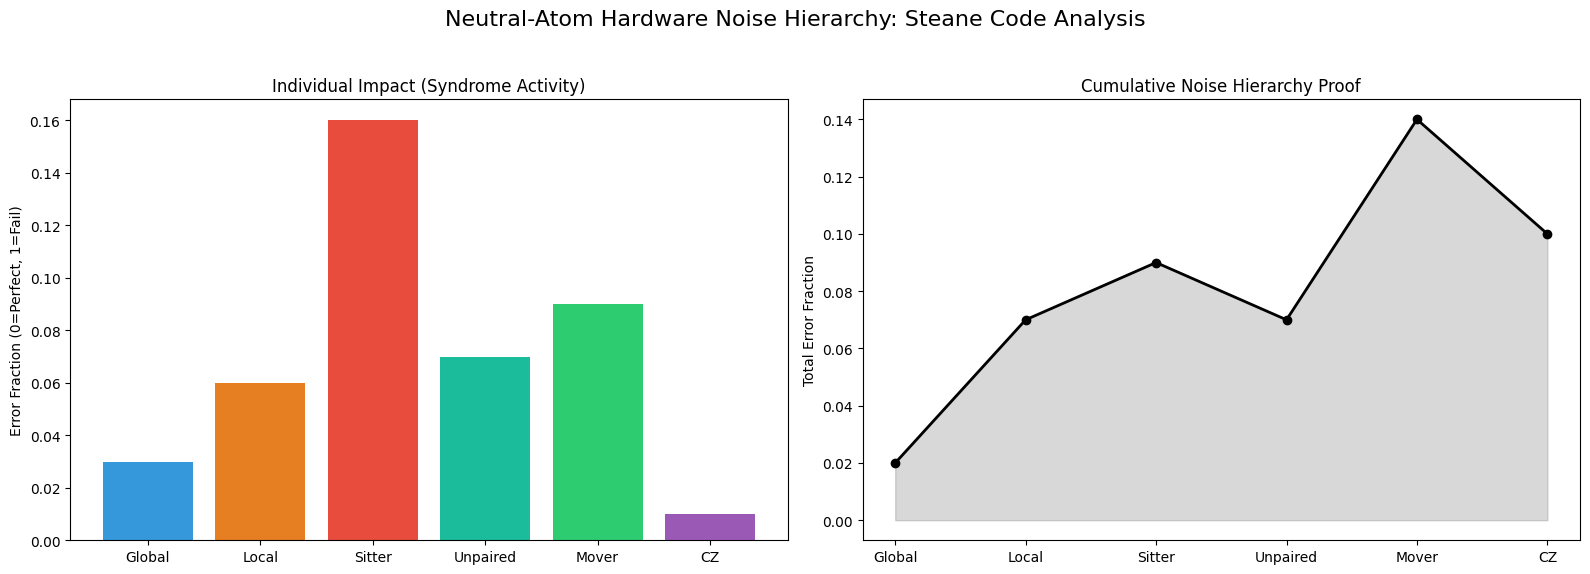

In [ ]:
#updated and commented
import matplotlib.pyplot as plt  # Library for creating the final graphs
import numpy as np  # Library for numerical operations
import cirq  # Google's framework for quantum circuit simulation
from bloqade.cirq_utils import noise  # Bloqade's specific tools for hardware noise


# --- 1. Define the Steane Code Encoding ---
# The Steane code is a 7-qubit Error Correcting Code.
# We use it because it's sensitive enough to detect hardware noise levels.
def get_steane_encode_circuit():
    """Returns a Cirq circuit for Steane encoding of logical |0>."""
    q = cirq.LineQubit.range(7)  # Define 7 physical qubits in a line
    circuit = cirq.Circuit()  # Initialize an empty quantum circuit

    # Step 1: Create a superposition on the 'source' qubits
    # These H (Hadamard) gates are the first potential source of noise.
    circuit.append([cirq.H(q[0]), cirq.H(q[1]), cirq.H(q[3])])

    # Step 2: Entangle the qubits using CNOT gates to spread the logical information.
    # Each CNOT here represents a 2-qubit interaction in the hardware.
    circuit.append([cirq.CNOT(q[0], q[2]), cirq.CNOT(q[1], q[2])])
    circuit.append([cirq.CNOT(q[0], q[4]), cirq.CNOT(q[3], q[4])])
    circuit.append([cirq.CNOT(q[1], q[5]), cirq.CNOT(q[3], q[5])])

    # Step 3: Final entanglement layer to complete the logical |0> state.
    circuit.append(
        [cirq.CNOT(q[0], q[6]), cirq.CNOT(q[1], q[6]), cirq.CNOT(q[3], q[6])]
    )

    return circuit  # Return the completed 7-qubit encoding circuit


# --- 2. Syndrome Measurement Logic ---
# This function measures how "damaged" the quantum state is after noise.
def run_error_fraction(noisy_circuit, shots=100):
    simulator = cirq.Simulator()  # Create the simulator engine
    qubits = sorted(list(noisy_circuit.all_qubits()))  # Get the list of qubits used
    # Append measurement gates to every qubit to read the final bitstrings
    measured_circuit = noisy_circuit + cirq.measure(*qubits, key="m")

    # Execute the simulation 'shots' times to get statistical data
    result = simulator.run(measured_circuit, repetitions=shots)
    measurements = result.measurements["m"]  # Extract the 1s and 0s

    # This sub-function performs "Parity Checks" (Syndromes)
    def check_syndrome(bits):
        # In a perfect Steane code, these parities must all be 0.
        # If any sum % 2 equals 1, a noise-induced error was detected.
        s1 = (bits[3] + bits[4] + bits[5] + bits[6]) % 2  # Check block 1
        s2 = (bits[1] + bits[2] + bits[5] + bits[6]) % 2  # Check block 2
        s3 = (bits[0] + bits[2] + bits[4] + bits[6]) % 2  # Check block 3
        # If any check is non-zero, the 'syndrome' is active (error exists)
        return s1 != 0 or s2 != 0 or s3 != 0

    # Count how many of the 100 shots failed the parity check
    error_count = sum(1 for bits in measurements if check_syndrome(bits))
    val = error_count / shots  # Convert count to a fraction (0.0 to 1.0)
    print(f" -> Error Fraction: {val:.4f}")  # Print progress to console
    return val  # Return the final error rate for this specific noise level


# --- 3. The Noise Hierarchy Simulation ---
# New Order: Global -> Local -> Sitter -> Unpaired -> Mover -> CZ
hierarchy_levels = ["Global", "Local", "Sitter", "Unpaired", "Mover", "CZ"]
individual_results = []  # To store impact of each source alone
cumulative_results = []  # To store the "Proof" (stacked noise)

# Define error rates (prob of bit-flip) based on QuEra hardware specs.
# Use actual QuEra Gemini defaults (from MoveNoiseModelABC)
rates = {
    "global": 6.5e-05,      # global_px/py/pz
    "local": 4.1e-04,       # local_px/py/pz (avg)
    "sitter": 4.6e-04,      # sitter_px/py/pz (avg)
    "unpaired": 2.2e-03,    # cz_unpaired total (px+py+pz)
    "mover": 2.5e-03,       # mover total (px+py+pz)
    "cz": 4.5e-03,          # cz_paired total (px+py+pz)
}


# The names of the parameters required by the Bloqade Gemini Noise Model
noise_keys = [
    "global_px",
    "global_py",
    "global_pz",
    "local_px",
    "local_py",
    "local_pz",
    "sitter_px",
    "sitter_py",
    "sitter_pz",
    "cz_unpaired_gate_px",
    "cz_unpaired_gate_py",
    "cz_unpaired_gate_pz",
    "mover_px",
    "mover_py",
    "mover_pz",
    "cz_paired_gate_px",
    "cz_paired_gate_py",
    "cz_paired_gate_pz",
]

encoding_circuit = get_steane_encode_circuit()  # Create the base circuit
accumulated_params = {k: 0.0 for k in noise_keys}  # Initialize total noise at zero

# Loop through each level to perform the hierarchical simulation
for level in hierarchy_levels:
    print(f"Simulating Level: {level}...")
    params = {k: 0.0 for k in noise_keys}  # Reset 'individual' params for this level

    # 3a. Map the human-readable 'level' to the specific hardware model parameters
    if level == "Global":
        # Global noise affects the X, Y, and Z axis equally across the array
        params["global_px"] = params["global_py"] = params["global_pz"] = rates[
            "global"
        ]
        accumulated_params["global_px"] = rates["global"]
    elif level == "Local":
        # Local noise represents individual beam errors on single qubits
        params["local_px"] = params["local_py"] = params["local_pz"] = rates["local"]
        accumulated_params["local_px"] = rates["local"]
    elif level == "Sitter":
        # Sitter noise is the decoherence of stationary atoms over time
        params["sitter_px"] = params["sitter_py"] = params["sitter_pz"] = rates[
            "sitter"
        ]
        accumulated_params["sitter_px"] = rates["sitter"]
    elif level == "Unpaired":
        # Noise on qubits that are nearby but not participating in a CZ gate
        params["cz_unpaired_gate_px"] = rates["unpaired"]
        accumulated_params["cz_unpaired_gate_px"] = rates["unpaired"]
    elif level == "Mover":
        # Noise introduced by the physical transport of atoms between zones
        params["mover_px"] = params["mover_py"] = params["mover_pz"] = rates["mover"]
        accumulated_params["mover_px"] = rates["mover"]
    elif level == "CZ":
        # The 2-qubit Rydberg gate noise (Highest in the hierarchy)
        params["cz_paired_gate_pz"] = rates[
            "cz"
        ]  # Mostly Z-type noise in Rydberg gates
        accumulated_params["cz_paired_gate_pz"] = rates["cz"]

    # 3b. Simulate Individual Impact:
    # Use the 'Gemini' model which mimics QuEra's physical architecture.
    model_ind = noise.GeminiTwoZoneNoiseModel(True, 1.0, None, None, **params)
    # Transform the clean circuit into a noisy one and run the simulation
    individual_results.append(
        run_error_fraction(noise.transform_circuit(encoding_circuit, model=model_ind))
    )

    # 3c. Simulate Cumulative Impact (The Hierarchy Proof):
    # This uses the 'accumulated_params' which keeps all previous noise sources active
    model_cum = noise.GeminiTwoZoneNoiseModel(
        True, 1.0, None, None, **accumulated_params
    )
    cumulative_results.append(
        run_error_fraction(noise.transform_circuit(encoding_circuit, model=model_cum))
    )

# --- 4. Visualization ---
# Create a figure with two side-by-side plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Bar chart showing how much error each source causes by itself
colors = [
    "#3498db",
    "#e67e22",
    "#e74c3c",
    "#1abc9c",
    "#2ecc71",
    "#9b59b6",
]  # Visual colors
ax1.bar(hierarchy_levels, individual_results, color=colors)  # Create the bars
ax1.set_title("Individual Impact (Syndrome Activity)")  # Label the title
ax1.set_ylabel("Error Fraction (0=Perfect, 1=Fail)")  # Label the Y axis

# Subplot 2: Line chart showing the cumulative "Stack" of noise
# This proves that as you add hardware complexity, the error grows predictably.
ax2.plot(
    hierarchy_levels, cumulative_results, marker="o", color="black", linewidth=2
)  # Draw line
ax2.fill_between(
    hierarchy_levels, cumulative_results, alpha=0.3, color="gray"
)  # Fill area
ax2.set_title("Cumulative Noise Hierarchy Proof")  # Label the title
ax2.set_ylabel("Total Error Fraction")  # Label the Y axis

# Final formatting and save the file
plt.suptitle("Neutral-Atom Hardware Noise Hierarchy: Steane Code Analysis", fontsize=16)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))  # Prevent titles from overlapping
plt.savefig("refined_noise_hierarchy.png")  # Save the proof as an image
plt.show()  # Display the plots to the user


Simulating Individual Level: Global...
 -> Error Fraction: 0.0000
Simulating Individual Level: Sitter...
 -> Error Fraction: 0.2000
Simulating Individual Level: Mover...
 -> Error Fraction: 0.1500
Simulating Individual Level: Local...
 -> Error Fraction: 0.1400
Simulating Individual Level: Gate...
 -> Error Fraction: 0.0300

Running Cumulative Proof...
 -> Error Fraction: 0.0400
 -> Error Fraction: 0.1400
 -> Error Fraction: 0.2400
 -> Error Fraction: 0.3600
 -> Error Fraction: 0.3300

Demonstration complete. Plot saved as 'noise_hierarchy_demonstration.png'.


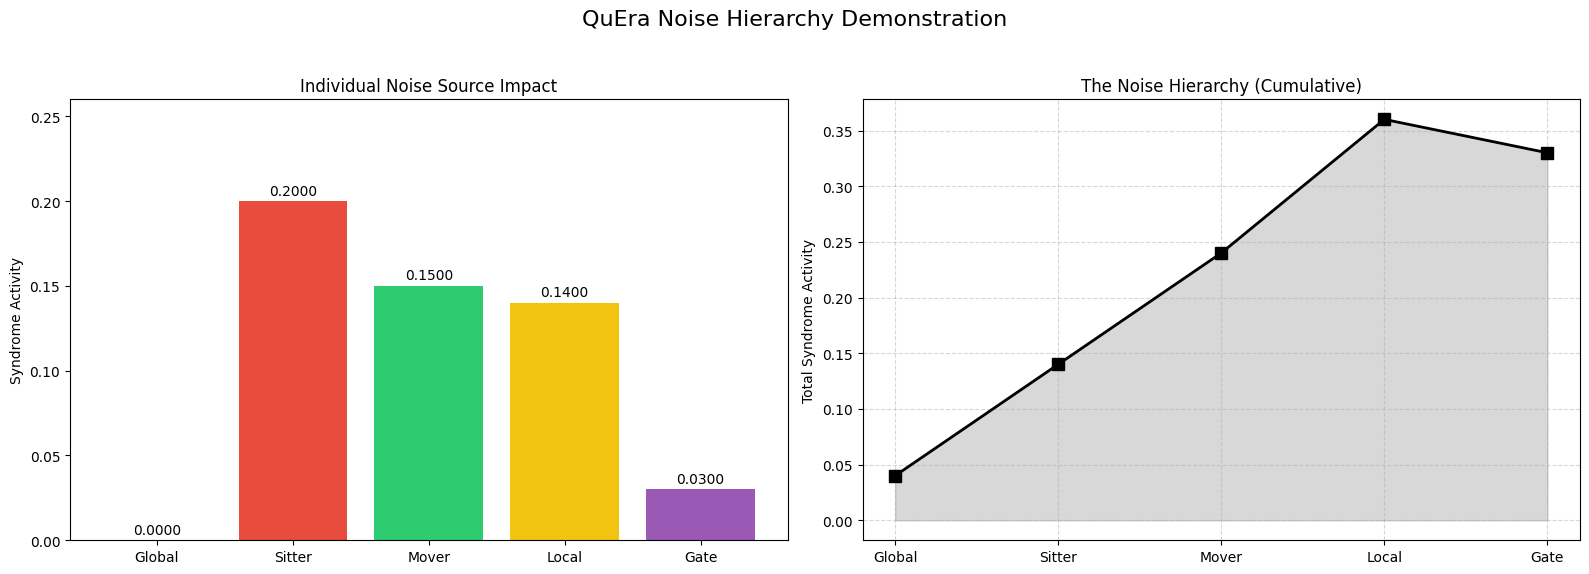

In [13]:
import matplotlib.pyplot as plt
import numpy as np
import cirq
from bloqade.cirq_utils import noise


# --- 1. Define the Steane Code Encoding ---
def get_steane_encode_circuit():
    """Returns a Cirq circuit for Steane encoding of |0>_L."""
    q = cirq.LineQubit.range(7)
    circuit = cirq.Circuit()

    # Standard Steane encoding
    circuit.append(cirq.H(q[0]))
    circuit.append(cirq.H(q[1]))
    circuit.append(cirq.H(q[3]))

    circuit.append(cirq.CNOT(q[0], q[2]))
    circuit.append(cirq.CNOT(q[1], q[2]))

    circuit.append(cirq.CNOT(q[0], q[4]))
    circuit.append(cirq.CNOT(q[3], q[4]))

    circuit.append(cirq.CNOT(q[1], q[5]))
    circuit.append(cirq.CNOT(q[3], q[5]))

    circuit.append(cirq.CNOT(q[0], q[6]))
    circuit.append(cirq.CNOT(q[1], q[6]))
    circuit.append(cirq.CNOT(q[3], q[6]))

    return circuit


# --- 2. Define the Syndrome Measurement logic ---
def run_error_fraction(noisy_circuit, shots=100):
    """Simulates the noisy circuit and calculates syndrome activity."""
    simulator = cirq.Simulator()
    # Ensure we measure all qubits used in the circuit
    qubits = sorted(list(noisy_circuit.all_qubits()))
    measured_circuit = noisy_circuit + cirq.measure(*qubits, key="m")

    result = simulator.run(measured_circuit, repetitions=shots)
    measurements = result.measurements["m"]

    def check_syndrome(bits):
        # Steane code parity checks (X-type syndromes)
        # S1: qubits 3,4,5,6
        # S2: qubits 1,2,5,6
        # S3: qubits 0,2,4,6
        s1 = (bits[3] + bits[4] + bits[5] + bits[6]) % 2
        s2 = (bits[1] + bits[2] + bits[5] + bits[6]) % 2
        s3 = (bits[0] + bits[2] + bits[4] + bits[6]) % 2
        return s1 != 0 or s2 != 0 or s3 != 0

    error_count = sum(1 for bits in measurements if check_syndrome(bits))
    val = error_count / shots
    print(f" -> Error Fraction: {val:.4f}")
    return val


# --- 3. Noise Hierarchy Simulation ---
hierarchy_levels = ["Global", "Sitter", "Mover", "Local", "Gate"]
individual_results = []

# Hardware-inspired error rates (slightly exaggerated for clear visualization)
rates = {
    "global": 5.0e-04,
    "sitter": 1.0e-03,
    "mover": 2.0e-03,
    "local": 5.0e-03,
    "gate": 2.0e-02,
}


encoding_circuit = get_steane_encode_circuit()

# Define keys for GeminiTwoZoneNoiseModel (keyword-only arguments)
noise_keys = [
    "local_px",
    "local_py",
    "local_pz",
    "global_px",
    "global_py",
    "global_pz",
    "cz_paired_gate_px",
    "cz_paired_gate_py",
    "cz_paired_gate_pz",
    "mover_px",
    "mover_py",
    "mover_pz",
    "sitter_px",
    "sitter_py",
    "sitter_pz",
]

for level in hierarchy_levels:
    print(f"Simulating Individual Level: {level}...")

    # Reset params to 0
    params = {k: 0.0 for k in noise_keys}

    if level == "Global":
        params["global_px"] = params["global_py"] = params["global_pz"] = rates[
            "global"
        ]
    elif level == "Sitter":
        params["sitter_px"] = params["sitter_py"] = params["sitter_pz"] = rates[
            "sitter"
        ]
    elif level == "Mover":
        params["mover_px"] = params["mover_py"] = params["mover_pz"] = rates["mover"]
    elif level == "Local":
        params["local_px"] = params["local_py"] = params["local_pz"] = rates["local"]
    elif level == "Gate":
        # Note: cz_paired_gate_pz is usually the highest in QuEra hardware
        params["cz_paired_gate_px"] = params["cz_paired_gate_py"] = rates["gate"] / 10
        params["cz_paired_gate_pz"] = rates["gate"]

    # Use explicit positional args to avoid LSP/Type confusion
    model = noise.GeminiTwoZoneNoiseModel(True, 1.0, None, None, **params)
    cirq_noisy = noise.transform_circuit(encoding_circuit, model=model)

    err_frac = run_error_fraction(cirq_noisy)
    individual_results.append(err_frac)

# --- 4. Cumulative Simulation ---
print("\nRunning Cumulative Proof...")
cumulative_results = []
accumulated_params = {k: 0.0 for k in noise_keys}

for level in hierarchy_levels:
    if level == "Global":
        accumulated_params["global_px"] = accumulated_params[
            "global_py"
        ] = accumulated_params["global_pz"] = rates["global"]
    elif level == "Sitter":
        accumulated_params["sitter_px"] = accumulated_params[
            "sitter_py"
        ] = accumulated_params["sitter_pz"] = rates["sitter"]
    elif level == "Mover":
        accumulated_params["mover_px"] = accumulated_params[
            "mover_py"
        ] = accumulated_params["mover_pz"] = rates["mover"]
    elif level == "Local":
        accumulated_params["local_px"] = accumulated_params[
            "local_py"
        ] = accumulated_params["local_pz"] = rates["local"]
    elif level == "Gate":
        accumulated_params["cz_paired_gate_px"] = accumulated_params[
            "cz_paired_gate_py"
        ] = rates["gate"] / 10
        accumulated_params["cz_paired_gate_pz"] = rates["gate"]

    model = noise.GeminiTwoZoneNoiseModel(True, 1.0, None, None, **accumulated_params)
    cirq_noisy = noise.transform_circuit(encoding_circuit, model=model)
    err_frac = run_error_fraction(cirq_noisy)
    cumulative_results.append(err_frac)

# --- 5. Visualization ---
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Subplot 1: Individual Impacts
colors = ["#3498db", "#e74c3c", "#2ecc71", "#f1c40f", "#9b59b6"]
bars = ax1.bar(hierarchy_levels, individual_results, color=colors)
ax1.set_ylabel("Syndrome Activity")
ax1.set_title("Individual Noise Source Impact")
ax1.set_ylim(0, max(individual_results) * 1.3)

for bar in bars:
    yval = bar.get_height()
    ax1.text(
        bar.get_x() + bar.get_width() / 2,
        yval + 0.002,
        f"{yval:.4f}",
        ha="center",
        va="bottom",
    )

# Subplot 2: Cumulative Proof
ax2.plot(
    hierarchy_levels,
    cumulative_results,
    marker="s",
    markersize=8,
    color="black",
    linewidth=2,
    label="Total Error",
)
ax2.fill_between(hierarchy_levels, cumulative_results, alpha=0.3, color="gray")
ax2.set_ylabel("Total Syndrome Activity")
ax2.set_title("The Noise Hierarchy (Cumulative)")
ax2.grid(True, linestyle="--", alpha=0.5)

plt.suptitle("QuEra Noise Hierarchy Demonstration", fontsize=16)
plt.tight_layout(rect=(0, 0.03, 1, 0.95))
plt.savefig("noise_hierarchy_demonstration.png")
print("\nDemonstration complete. Plot saved as 'noise_hierarchy_demonstration.png'.")


In [ ]:
#9:29 pm


In [6]:
# --- SITTER NOISE ISOLATION ---

# Import the noise transformation utilities from Bloqade
from bloqade.cirq_utils import noise 

# Convert the previously defined 'a3_circuit' (Bloqade kernel) into a Cirq circuit object
# This is required because the noise transformer operates on Cirq-formatted circuits.
cirq_enc = emit_circuit(a3_circuit)

# Apply the hardware-specific noise transformation
cirq_noisy = noise.transform_circuit(
    cirq_enc, # The original noiseless circuit
    model=noise.GeminiTwoZoneNoiseModel(
        # SITTER noise: Pauli error probabilities for qubits in the 'storage' zone.
        # These values represent the decoherence floor for stationary qubits.
        sitter_px=3.066e-04, # Probability of an X (bit-flip) error
        sitter_py=3.066e-04, # Probability of a Y error
        sitter_pz=4.639e-04, # Probability of a Z (phase-flip) error

        # --- ISOLATION STEP ---
        # To isolate ONLY Sitter noise, we explicitly set all other noise channels to 0.0.
        # This prevents Mover noise, Global noise, or Gate noise from skewing the results.
        mover_px=0.0, mover_py=0.0, mover_pz=0.0,
        global_px=0.0, global_py=0.0, global_pz=0.0,
        local_px=0.0, local_py=0.0, local_pz=0.0,
        local_unaddressed_px=0.0, local_unaddressed_py=0.0, local_unaddressed_pz=0.0,
        cz_paired_gate_px=0.0, cz_paired_gate_py=0.0, cz_paired_gate_pz=0.0,
        cz_unpaired_gate_px=0.0, cz_unpaired_gate_py=0.0, cz_unpaired_gate_pz=0.0,
    )
)

# Run the noisy circuit through the Stim-based simulator helper function.
# This returns the fraction of shots that detected an error (err_frac) and the raw data.
err_frac, samples_enc = run_error_fraction(cirq_noisy, shots=500)

# Print output labels for clarity
print("SITTER noise only")
print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")

# Display the dimensions of the result: (Number of shots, Number of measurement bits)
print("Sample shape:", samples_enc.shape)

# Print the bitstrings for the first 5 simulations to see the raw syndrome data
print("First 5 shots:\n", samples_enc[:5])

# Print the final calculated error fraction (Syndrome Activity)
print(err_frac)


KeyboardInterrupt: 

In [34]:
# global 


# ---------------------------------------------------------------------------
# Execute and sample
# ---------------------------------------------------------------------------
cirq_enc = emit_circuit(a3_circuit)
#ADD NOISE CHANNEL
squin_enc = load_circuit(cirq_enc)
stim_enc = bloqade.stim.Circuit(squin_enc)
sampler = stim_enc.compile_sampler()
samples_enc = np.array(sampler.sample(shots=500))

print("MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)")
print("Sample shape:", samples_enc.shape)
print("First 5 shots:\n", samples_enc[:5])
print(np.count_nonzero(samples_enc)/len(samples_enc))

MSD/Steane encoding A3 circuit: 15 qubits (7 data + 7 ancilla + 1 unused)
Sample shape: (500, 14)
First 5 shots:
 [[ True False False False False  True  True  True  True  True False False
   True  True]
 [False False False False False False False  True  True False False False
  False False]
 [ True  True  True  True  True  True  True False False False False False
   True  True]
 [False  True False  True False  True False  True  True False False False
  False  True]
 [ True False False False False  True  True  True  True  True False False
   True  True]]
7.036


In [7]:
import matplotlib.pyplot as plt
import numpy as np
from bloqade.cirq_utils import noise, emit_circuit

# --- 1. Define the Levels and Parameters ---
hierarchy_levels = ["Global", "Sitter", "Mover", "Local", "Gate"]
results = []

# Typical hardware error rates for demonstration
rates = {
    "global": 6.5e-05,
    "sitter": 3.0e-04,
    "mover": 5.0e-04,
    "local": 2.0e-04,
    "gate": 1.5e-02 # CZ gates are usually the highest error source
}

# --- 2. Iterate through the Hierarchy ---
for level in hierarchy_levels:
    print(f"Simulating Level: {level}...")
    
    # Start with a clean TwoZone model (all zeros)
    model_params = {k: 0.0 for k in [
        'global_px', 'global_py', 'global_pz',
        'sitter_px', 'sitter_py', 'sitter_pz',
        'mover_px', 'mover_py', 'mover_pz',
        'local_px', 'local_py', 'local_pz',
        'cz_paired_gate_px', 'cz_paired_gate_py', 'cz_paired_gate_pz'
    ]}
    
    # Activate ONLY the current level
    if level == "Global":
        model_params['global_px'] = model_params['global_py'] = model_params['global_pz'] = rates['global']
    elif level == "Sitter":
        model_params['sitter_px'] = model_params['sitter_py'] = model_params['sitter_pz'] = rates['sitter']
    elif level == "Mover":
        model_params['mover_px'] = model_params['mover_py'] = model_params['mover_pz'] = rates['mover']
    elif level == "Local":
        model_params['local_px'] = model_params['local_py'] = model_params['local_pz'] = rates['local']
    elif level == "Gate":
        model_params['cz_paired_gate_px'] = rates['gate']

    # Apply noise to the 7-qubit encoding (faster for demonstration)
    cirq_noisy = noise.transform_circuit(
        emit_circuit(steane_encode_zero_on), 
        model=noise.GeminiTwoZoneNoiseModel(**model_params)
    )
    
    # Run simulation (using the helper function you defined earlier)
    err_frac, _ = run_error_fraction(cirq_noisy, shots=300)
    results.append(err_frac)

# --- 3. Visualization ---
plt.figure(figsize=(10, 6))
bars = plt.bar(hierarchy_levels, results, color=['#3498db', '#e74c3c', '#2ecc71', '#f1c40f', '#9b59b6'])

plt.ylabel('Syndrome Activity (Error Fraction)')
plt.title('QuEra Noise Hierarchy: Impact on Steane Encoding')
plt.ylim(0, max(results) * 1.2)

# Add labels on top of bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.005, f"{yval:.4f}", ha='center', va='bottom')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Simulating Level: Global...


ValueError: The method from which you're trying to emit a circuit takes 1 as input, but you passed in 0 via the `args` keyword!